# Simulador de quemador de gas


En la siguiente práctica, simularemos el comportamiento de un quemador de gas. El quemador tiene un sensor de temperatura y un actuador que regula la cantidad de gas quemada. El objetivo es mantener la temperatura en 100 grados Celsius. El quemador tiene un comportamiento no lineal, por lo que es difícil de controlar.

Al principio, el quemador está apagado y la temperatura es de 20 grados centígrados. El quemador se enciende y la temperatura aumenta. Cuando la temperatura alcanza los 100 grados Celsius, si apagamos el quemador, la temperatura disminuye. Si encendemos el quemador, la temperatura aumenta y sobrepasamos los 100 grados Celsius. Necesitamos modificar la cantidad de gas que quemamos para mantener la temperatura en 100 grados Celsius de manera constante.


## Pasos previos

Necesitamos instalar la libreria scikit-fuzzy, pero no podemos usar la última versión (0.5), con la 0.4.2 es suficiente.

In [1]:
%pip install scikit-fuzzy==0.4.2 #La libreria 0.5 es más reciente pero tiene problemas con el ControlSystem.view()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894076 sha256=c7471c86a1fc4fe33e59a06b6847199577958c0444a72c62ee36afba67da765d
  Stored in directory: /root/.cache/pip/wheels/b1/67/d1/6c29aeb1cd2d36447ad5b0de027580b8894aff702a9b50041e
Successfully built scikit-fuzzy


# Implementación simple

Primero, implementaremos un controlador simple que intente mantener la temperatura en 100 grados Celsius. El controlador será una función en la que pasamos la temperatura actual y nos devuelve la cantidad de gas que debemos quemar (entre 0 y 100).

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def controlador_simple(temperatura):
    # Escribe aquí el código para el controlador simple (Ejemplo: proporcional)
    # Por ahora devolvemos un valor fijo o una lógica simple para probar
    if temperatura < 100:
        return 80
    else:
        return 20


## Efecto sobre la temperatura

Dependiendo de la cantidad de gas quemado, la temperatura aumenta o disminuye. Asumiremos que la temperatura aumenta 1 grado Celsius por segundo si quemamos 1 unidad de gas y disminuye 0.5 grados Celsius por segundo si no quemamos nada. Los valores intermedios son proporcionales.

La función será la siguiente:

In [3]:
def temperatura(t_actual, gas):
    # Función que define la física del quemador
    gas = gas / 100
    return t_actual + gas - 0.5 * (1 - gas)

## Simulamos el quemador.

Ahora simulemos el quemador. El quemador tiene un sensor de temperatura y un actuador regula la cantidad de gas quemado. El quemador tiene un comportamiento no lineal, por lo que es difícil de controlar. El controlador debe poder mantener la temperatura en 100 grados centígrados.

Visualizamos la temperatura y la cantidad de gas que quemamos durante 100 segundos.

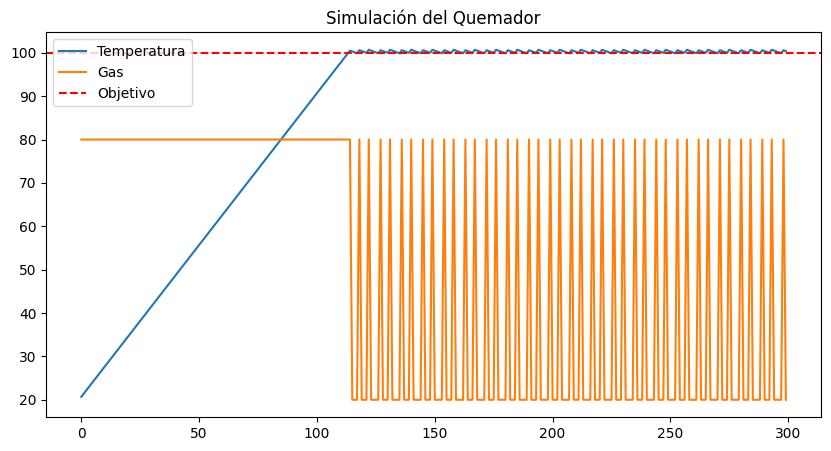

In [4]:
def simulador(controlador, t_inicial=20, pasos=300):
    temps = np.zeros(pasos)
    gasos = np.zeros(pasos)
    for p in range(pasos):
        gas = controlador(t_inicial)
        t_inicial = temperatura(t_inicial, gas)
        temps[p] = t_inicial
        gasos[p] = gas

    plt.figure(figsize=(10, 5))
    plt.plot(temps)
    plt.plot(gasos)
    plt.axhline(y=100, color='r', linestyle='--', label='Objetivo')
    plt.legend(['Temperatura', 'Gas', 'Objetivo'])
    plt.title("Simulación del Quemador")
    plt.show()

# Probamos el controlador simple
simulador(controlador_simple)

Podemos ver cómo funciona el sistema pero no es estable. Una vez que la temperatura alcanza los 100 grados, el sistema no puede mantener la temperatura en 100 grados de manera efectiva.

Veamos una forma más efectiva de controlar el sistema.

# Implementación en lógica difusa

La lógica difusa es la herramienta perfecta para este tipo de problema. Nos permite modelar el comportamiento del sistema de manera intuitiva y fácil; devueltos valores continuos en lugar de valores discretos.

Utilizaremos la librería Scikit-Fuzzy para implementar el controlador difuso. Esta librería nos permite definir conjuntos difusos, reglas difusas e inferencia fácilmente.

Primero, definimos los conjuntos difusos que usaremos para modelar el sistema. En este caso, usaremos cuatro conjuntos difusos para modelar la temperatura: muy frio, frío, apropiado y muy caliente. Y cinco conjuntos difusos para modelar la cantidad de gas que quemamos: muy poco, poco, mediano, mucho y total.

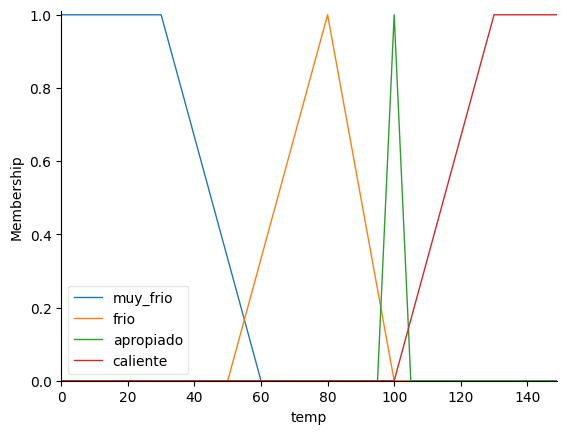

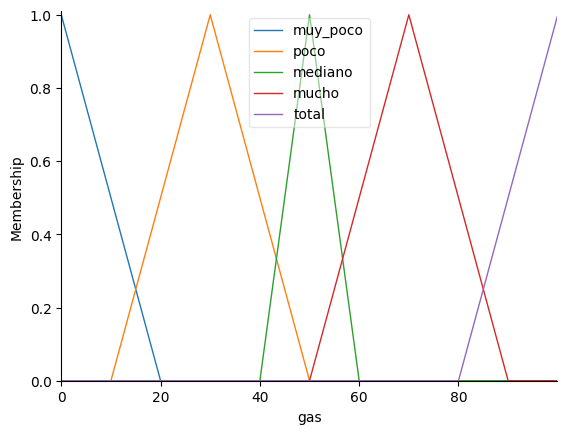

In [5]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# La temperatura objetivo estará en el centro del conjunto apropiado
temperatura_obj = 100

# Definimos el universo del discurso
rango_temperatura = np.arange(0, 150, 1)
rango_gas = np.arange(0, 100, 0.1)

# Definimos los antecedentes y el consecuente
temp = ctrl.Antecedent(rango_temperatura, 'temp')
gas = ctrl.Consequent(rango_gas, 'gas')

# --- AQUÍ DEBES DEFINIR LOS CONJUNTOS DIFUSOS (fuzz.trimf o fuzz.trapmf) ---
# Ejemplo rápido para que no de error al visualizar:
temp['muy_frio'] = fuzz.trapmf(temp.universe, [0, 0, 30, 60])
temp['frio'] = fuzz.trimf(temp.universe, [50, 80, 100])
temp['apropiado'] = fuzz.trimf(temp.universe, [95, 100, 105])
temp['caliente'] = fuzz.trapmf(temp.universe, [100, 130, 150, 150])

gas['muy_poco'] = fuzz.trimf(gas.universe, [0, 0, 20])
gas['poco'] = fuzz.trimf(gas.universe, [10, 30, 50])
gas['mediano'] = fuzz.trimf(gas.universe, [40, 50, 60])
gas['mucho'] = fuzz.trimf(gas.universe, [50, 70, 90])
gas['total'] = fuzz.trimf(gas.universe, [80, 100, 100])

# Visualizamos conjuntos difusos
temp.view()
gas.view()

## Reglas difusas

Ahora definimos las reglas difusas que modelan el comportamiento del sistema.
En este caso, definiremos cinco reglas difusas:
- Si la temperatura es muy fría, quemaremos todo el gas.
- Si la temperatura es fría, quemaremos mucho gas.
- Si la temperatura es apropiada, quemaremos una cantidad adecuada de gas.
- Si la temperatura está caliente, quemaremos poco gas.


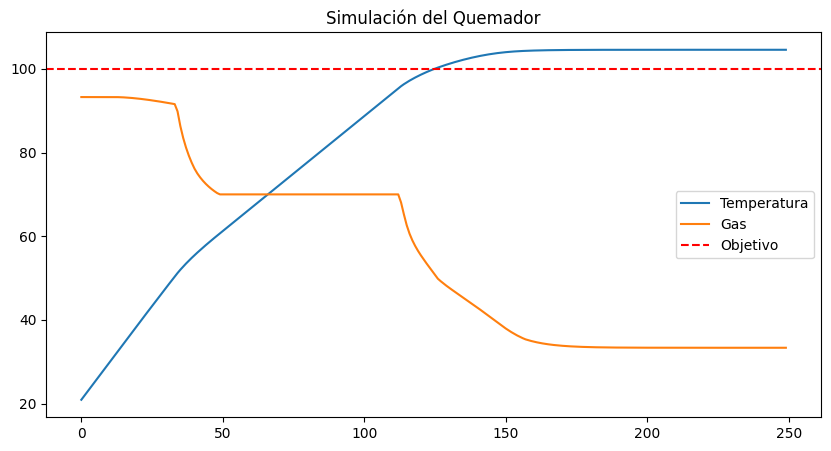

In [6]:
# Define aquí las reglas basadas en los nombres que pusiste arriba
regla1 = ctrl.Rule(temp['muy_frio'], gas['total'])
regla2 = ctrl.Rule(temp['frio'], gas['mucho'])
regla3 = ctrl.Rule(temp['apropiado'], gas['mediano'])
regla4 = ctrl.Rule(temp['caliente'], gas['poco'])


controlador_cntl = ctrl.ControlSystem([regla1, regla2, regla3,regla4])
controlador_simulador = ctrl.ControlSystemSimulation(controlador_cntl)

def controlador_difuso(temperatura):
    controlador_simulador.input['temp'] = temperatura
    controlador_simulador.compute()
    return controlador_simulador.output['gas']

# Ejecutamos la simulación con el motor difuso
simulador(controlador_difuso, 20, 250)

## Inferencia difusa

Ahora definimos el controlador difuso. El controlador difuso es un sistema difuso que utiliza las reglas difusas para inferir el valor de la salida.
En este caso, el controlador difuso utiliza las reglas difusas para inferir la cantidad de gas que tenemos que quemar para mantener la temperatura en 100 grados Celsius.

In [9]:
controlador = ctrl.ControlSystem([regla1, regla2, regla3, regla4])

In [10]:
controlador_simulador = ctrl.ControlSystemSimulation(controlador)

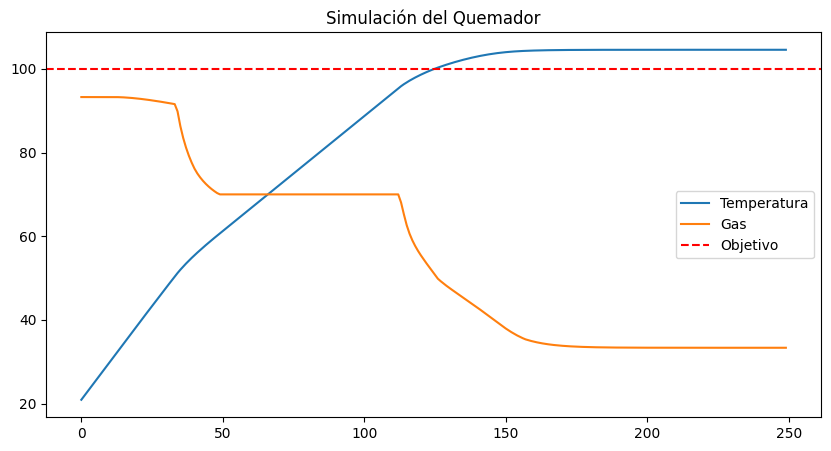

In [12]:
# Simulamos controlador difuso

def controlador_difuso(temperatura):
    controlador_simulador.input['temp'] = temperatura
    controlador_simulador.compute()
    return controlador_simulador.output['gas']

simulador(controlador_difuso, 20, 250)

# Enfoque alternativo

Un enfoque similar pero con un resultado diferente sería el siguiente: como entrada, recibiremos el error de temperatura (la diferencia entre la temperatura actual y la temperatura objetivo). Como salida, devolveremos la cantidad de gas que debemos quemar.

La diferencia entre este enfoque y el enfoque anterior es que en este caso, el controlador difuso no tiene que saber cuál es la temperatura actual. Solo tiene que saber cuál es la diferencia entre la temperatura actual y la temperatura objetivo. También lo hará más flexible y fácil de reutilizar.

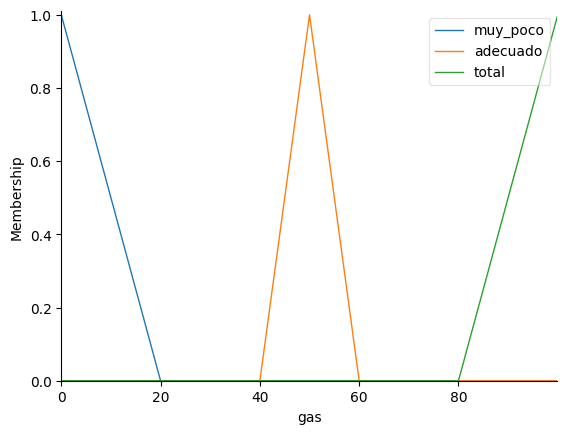

In [13]:
# Definimos el universo del discurso

teperatura_objetivo = 100

rango_error = np.arange(-teperatura_objetivo, teperatura_objetivo, 1)
rango_gas = np.arange(0, 100, 0.1)

# Definimos los antecedentes y el consecuente
error = ctrl.Antecedent(rango_error, 'error')
gas = ctrl.Consequent(rango_gas, 'gas')

# --- CONJUNTOS DIFUSOS PARA EL ERROR ---
# Si el error es negativo, significa que falta temperatura (está frío)
error['frio'] = fuzz.trapmf(error.universe, [-100, -100, -50, 0])
# El error cero es el objetivo ideal
error['cero'] = fuzz.trimf(error.universe, [-5, 0, 5])
# Si el error es positivo, sobra temperatura (está caliente)
error['caliente'] = fuzz.trapmf(error.universe, [0, 50, 100, 100])

# --- CONJUNTOS DIFUSOS PARA EL GAS ---
# Mínima cantidad de gas
gas['muy_poco'] = fuzz.trimf(gas.universe, [0, 0, 20])
# Cantidad ideal para mantener 100°C (el equilibrio físico suele estar en 50)
gas['adecuado'] = fuzz.trimf(gas.universe, [40, 50, 60])
# Máxima potencia
gas['total'] = fuzz.trimf(gas.universe, [80, 100, 100])


gas.view()

## Nuevas reglas difusas

Ahora definimos las reglas difusas que modelan el comportamiento del sistema.
En este caso, definiremos solo tres reglas difusas:
- Si la diferencia con la temperatura es frio, quemaremos todo el gas.
- Si la diferencia con la temperatura es cero, quemaremos una cantidad adecuada.
- Si la diferencia con la temperatura es caliente, quemaremos muy poco gas.


In [14]:
# 1. Definimos las reglas difusas (Relación entre error y gas)
regla1 = ctrl.Rule(error['frio'], gas['total'])        # Si falta mucha temp, gas al máximo
regla2 = ctrl.Rule(error['cero'], gas['adecuado'])    # Si estamos en el objetivo, gas al 50%
regla3 = ctrl.Rule(error['caliente'], gas['muy_poco']) # Si sobra temp, casi nada de gas

# 2. Definimos el sistema de control (el motor de reglas)
controlador = ctrl.ControlSystem([regla1, regla2, regla3])

# 3. Creamos la simulación del sistema
controlador_simulador = ctrl.ControlSystemSimulation(controlador)

# Visualizamos el sistema de control (opcional, genera el diagrama lógico)
# controlador.view()

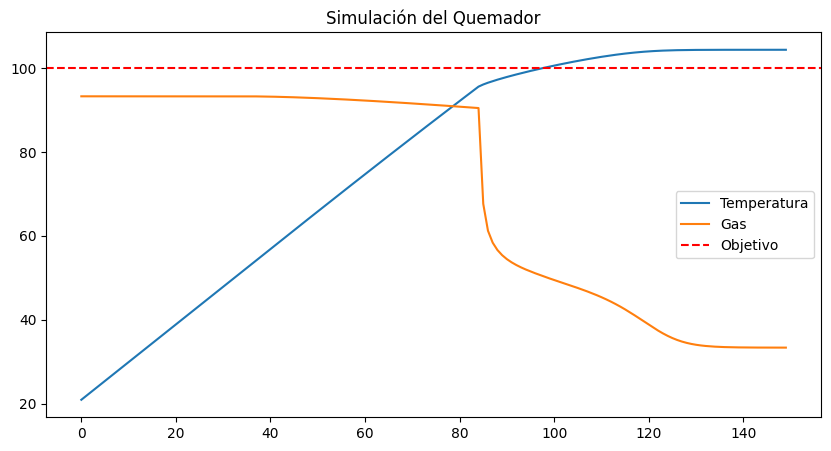

In [15]:
# Simulamos controlador difuso

controlador_simulador = ctrl.ControlSystemSimulation(controlador)

def controlador_difus(temperatura):
    controlador_simulador.input['error'] = temperatura - teperatura_objetivo
    controlador_simulador.compute()
    return controlador_simulador.output['gas']

simulador(controlador_difus, 20, 150)

# Entrega

Una vez completado el Notebook y ejecutado completamente (comprueba que funcionan todas las celdas). Envialo a la tarea correspondiente de AULES.